## Run cells and re-start runtime 

In [ ]:
! pip install tensorflow_privacy

## Download IMDB Dataset


In [2]:
## import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_data, test_data = tfds.load(name='imdb_reviews', split=['train', 'test'], batch_size=-1, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWV8RLG/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWV8RLG/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWV8RLG/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
X_train, y_train = tfds.as_numpy(train_data)
X_test, y_test = tfds.as_numpy(test_data)

## Explore dataset

In [ ]:
print(f"Size of Train and Test datasets : {len(X_train)}, {len(X_test)}")

Size of Train and Test datasets : 25000, 25000


In [ ]:
## sample ones
for index in range(5):
  print(f"{index} sentence: {X_train[index]}\n Label :- {y_train[index]}")

0 sentence: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 Label :- 0
1 sentence: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film w

## Build Base Model


In [ ]:
embedding_model = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
embedding_layer = hub.KerasLayer(embedding_model, input_shape=[], dtype=tf.string, trainable=True)
sample = embedding_layer(X_train[:2])

## build model
model = tf.keras.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

print(f"Summary Of the Model :- {model.summary()}")

model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## create validation dataset
X_val = X_train[:10000]
partial_X_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(partial_X_train, partial_y_train, batch_size=250, epochs=50, callbacks=[es], verbose=1, validation_data=(X_val, y_val))

### Model evaluating 

In [ ]:
results = model.evaluate(X_test, y_test)

In [ ]:
import os  
import tensorflow as tf
from datetime import datetime

now = datetime.now()
now.strftime("%H:%M:%S.%f")

root_path = '/content/drive/Shareddrives/SecureML/ProjectSubmission/Code'
model.save(root_path+f'/TextClassifier'+now.strftime("%H:%M:%S.%f"))

# Adding DP-SGD

In [67]:
import tensorflow_hub as hub
import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

### private model v1
Epsilon = 3, Noise multiplier = 1.0630,  Clipping parameter = 1

In [68]:
# l2_norm_clip = 1.5 noise_multiplier = 1.3
epochs = 15
batch_size = 250
l2_norm_clip = 1
noise_multiplier = 1.063
num_microbatches = 250
learning_rate = 0.25



if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [69]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

In [74]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
                           input_shape=[], dtype=tf.string)

## build model
modelpriv1 = tf.keras.Sequential()
modelpriv1.add(hub_layer)
modelpriv1.add(tf.keras.layers.Dense(64, activation='relu'))
modelpriv1.add(tf.keras.layers.Dense(16, activation='relu'))
modelpriv1.add(tf.keras.layers.Dense(1))


modelpriv1.summary()
modelpriv1.compile(optimizer = optimizer, loss=loss, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 16)                1040      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,652,001
Trainable params: 9,313
Non-trainable params: 124,642,688
_________________________________________________________________


In [75]:
## create validation dataset
X_val = X_train[:10000]
partial_X_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = modelpriv1.fit(partial_X_train, partial_y_train, batch_size=250, epochs=15, verbose=1, validation_data=(X_val, y_val))

Epoch 1/15
60/60 [==============================] - 7s 82ms/step - loss: 0.6510 - accuracy: 0.5386 - val_loss: 0.5960 - val_accuracy: 0.6361
Epoch 2/15
60/60 [==============================] - 5s 86ms/step - loss: 0.5891 - accuracy: 0.6759 - val_loss: 0.6209 - val_accuracy: 0.6910
Epoch 3/15
60/60 [==============================] - 5s 91ms/step - loss: 0.6091 - accuracy: 0.7197 - val_loss: 0.6378 - val_accuracy: 0.7235
Epoch 4/15
60/60 [==============================] - 5s 89ms/step - loss: 0.6215 - accuracy: 0.7452 - val_loss: 0.6268 - val_accuracy: 0.7523
Epoch 5/15
60/60 [==============================] - 5s 80ms/step - loss: 0.6101 - accuracy: 0.7626 - val_loss: 0.6374 - val_accuracy: 0.7572
Epoch 6/15
60/60 [==============================] - 5s 80ms/step - loss: 0.6011 - accuracy: 0.7749 - val_loss: 0.6204 - val_accuracy: 0.7744
Epoch 7/15
60/60 [==============================] - 5s 83ms/step - loss: 0.6024 - accuracy: 0.7855 - val_loss: 0.6145 - val_accuracy: 0.7863
Epoch 8/15
60

In [70]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=partial_X_train.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 1.67% and noise_multiplier = 1.063 iterated over 900 steps satisfies differential privacy with eps = 3 and delta = 1e-05.
The optimal RDP order is 7.0.


(3.0014894755884276, 7.0)

In [76]:
results = modelpriv1.evaluate(X_test, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.6606 - accuracy: 0.8016


### private model v2
Epsilon = 5, Noise multiplier = 0.8465,  Clipping parameter = 1

In [77]:
# l2_norm_clip = 2 noise_multiplier = 1.3
epochs = 3
batch_size = 250
l2_norm_clip = 1
noise_multiplier = 0.8465
num_microbatches = 250
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')

optimizer_2 = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss_2 = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)


In [78]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
                           input_shape=[], dtype=tf.string)

modelpriv2 = tf.keras.Sequential()
modelpriv2.add(hub_layer)
modelpriv2.add(tf.keras.layers.Dense(64, activation='relu'))
modelpriv2.add(tf.keras.layers.Dense(16, activation='relu'))
modelpriv2.add(tf.keras.layers.Dense(1))


modelpriv2.summary()
modelpriv2.compile(optimizer = optimizer_2, loss=loss_2, metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 124,652,001
Trainable params: 9,313
Non-trainable params: 124,642,688
_________________________________________________________________


In [79]:
## create validation dataset
X_val = X_train[:10000]
partial_X_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]


#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = modelpriv2.fit(partial_X_train, partial_y_train, batch_size=250, epochs=15, verbose=1, validation_data=(X_val, y_val))

Epoch 1/15
60/60 [==============================] - 7s 81ms/step - loss: 0.6504 - accuracy: 0.5697 - val_loss: 0.5830 - val_accuracy: 0.6275
Epoch 2/15
60/60 [==============================] - 5s 79ms/step - loss: 0.5494 - accuracy: 0.6871 - val_loss: 0.5340 - val_accuracy: 0.7306
Epoch 3/15
60/60 [==============================] - 5s 82ms/step - loss: 0.5518 - accuracy: 0.7385 - val_loss: 0.5677 - val_accuracy: 0.7551
Epoch 4/15
60/60 [==============================] - 5s 80ms/step - loss: 0.5686 - accuracy: 0.7605 - val_loss: 0.5881 - val_accuracy: 0.7624
Epoch 5/15
60/60 [==============================] - 5s 85ms/step - loss: 0.5753 - accuracy: 0.7747 - val_loss: 0.6072 - val_accuracy: 0.7671
Epoch 6/15
60/60 [==============================] - 5s 82ms/step - loss: 0.5810 - accuracy: 0.7873 - val_loss: 0.6008 - val_accuracy: 0.7859
Epoch 7/15
60/60 [==============================] - 5s 81ms/step - loss: 0.5878 - accuracy: 0.7942 - val_loss: 0.6075 - val_accuracy: 0.7928
Epoch 8/15
60

In [80]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=partial_X_train.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 1.67% and noise_multiplier = 0.8465 iterated over 180 steps satisfies differential privacy with eps = 2.88 and delta = 1e-05.
The optimal RDP order is 5.0.


(2.8803267030263697, 5.0)

### private model v3
Epsilon = 3, Noise multiplier = 1.0630, Clipping parameter = 1.3

In [81]:
# l2_norm_clip = 1.5, noise_multiplier = 1.6
epochs = 3
batch_size = 250
l2_norm_clip = 1.3
noise_multiplier = 1.063
num_microbatches = 250
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')


optimizer_3 = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss_3 = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)


In [82]:

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
                           input_shape=[], dtype=tf.string)


## build model
modelpriv3 = tf.keras.Sequential()
modelpriv3.add(hub_layer)
modelpriv3.add(tf.keras.layers.Dense(64, activation='relu'))
modelpriv3.add(tf.keras.layers.Dense(16, activation='relu'))
modelpriv3.add(tf.keras.layers.Dense(1))


modelpriv3.summary()
modelpriv3.compile(optimizer = optimizer_3, loss=loss_3, metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 124,652,001
Trainable params: 9,313
Non-trainable params: 124,642,688
_________________________________________________________________


In [83]:
## create validation dataset
X_val = X_train[:10000]
partial_X_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = modelpriv3.fit(partial_X_train, partial_y_train, batch_size=250, epochs=15, verbose=1, validation_data=(X_val, y_val))

Epoch 1/15
60/60 [==============================] - 7s 84ms/step - loss: 0.6558 - accuracy: 0.5345 - val_loss: 0.5819 - val_accuracy: 0.6418
Epoch 2/15
60/60 [==============================] - 5s 84ms/step - loss: 0.5601 - accuracy: 0.7076 - val_loss: 0.5624 - val_accuracy: 0.7352
Epoch 3/15
60/60 [==============================] - 5s 80ms/step - loss: 0.5670 - accuracy: 0.7505 - val_loss: 0.5772 - val_accuracy: 0.7585
Epoch 4/15
60/60 [==============================] - 5s 82ms/step - loss: 0.5675 - accuracy: 0.7741 - val_loss: 0.5913 - val_accuracy: 0.7695
Epoch 5/15
60/60 [==============================] - 5s 83ms/step - loss: 0.5666 - accuracy: 0.7867 - val_loss: 0.5972 - val_accuracy: 0.7782
Epoch 6/15
60/60 [==============================] - 5s 81ms/step - loss: 0.5750 - accuracy: 0.7939 - val_loss: 0.5900 - val_accuracy: 0.7889
Epoch 7/15
60/60 [==============================] - 5s 80ms/step - loss: 0.5811 - accuracy: 0.7981 - val_loss: 0.5936 - val_accuracy: 0.8019
Epoch 8/15
60

In [84]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=partial_X_train.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 1.67% and noise_multiplier = 1.063 iterated over 180 steps satisfies differential privacy with eps = 1.61 and delta = 1e-05.
The optimal RDP order is 8.0.


(1.6137937439402754, 8.0)

### private model v4
Epsilon = 5,  Noise multiplier = 0.8465, Clipping parameter = 1.3

In [85]:
# l2_norm_clip = 1.5, noise_multiplier = 1.6
epochs = 3
batch_size = 250
l2_norm_clip = 1.3
noise_multiplier = 0.8465
num_microbatches = 250
learning_rate = 0.25

if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')


optimizer_3 = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss_3 = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)


In [86]:

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2",
                           input_shape=[], dtype=tf.string)

## build model
modelpriv4 = tf.keras.Sequential()
modelpriv4.add(hub_layer)
modelpriv4.add(tf.keras.layers.Dense(64, activation='relu'))
modelpriv4.add(tf.keras.layers.Dense(16, activation='relu'))
modelpriv4.add(tf.keras.layers.Dense(1))


modelpriv4.summary()
modelpriv4.compile(optimizer = optimizer_3, loss=loss_3, metrics=['accuracy'])



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 124,652,001
Trainable params: 9,313
Non-trainable params: 124,642,688
_________________________________________________________________


In [87]:
## create validation dataset
X_val = X_train[:10000]
partial_X_train = X_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

history = modelpriv4.fit(partial_X_train, partial_y_train, batch_size=250, epochs=15, verbose=1, validation_data=(X_val, y_val))

Epoch 1/15
60/60 [==============================] - 7s 84ms/step - loss: 0.6595 - accuracy: 0.5154 - val_loss: 0.6256 - val_accuracy: 0.5763
Epoch 2/15
60/60 [==============================] - 5s 81ms/step - loss: 0.5915 - accuracy: 0.6707 - val_loss: 0.5693 - val_accuracy: 0.7227
Epoch 3/15
60/60 [==============================] - 5s 81ms/step - loss: 0.5742 - accuracy: 0.7418 - val_loss: 0.6080 - val_accuracy: 0.7378
Epoch 4/15
60/60 [==============================] - 5s 80ms/step - loss: 0.5724 - accuracy: 0.7649 - val_loss: 0.5736 - val_accuracy: 0.7752
Epoch 5/15
60/60 [==============================] - 5s 79ms/step - loss: 0.5709 - accuracy: 0.7836 - val_loss: 0.5844 - val_accuracy: 0.7817
Epoch 6/15
60/60 [==============================] - 5s 81ms/step - loss: 0.5748 - accuracy: 0.7915 - val_loss: 0.5991 - val_accuracy: 0.7872
Epoch 7/15
60/60 [==============================] - 5s 80ms/step - loss: 0.5764 - accuracy: 0.7961 - val_loss: 0.6049 - val_accuracy: 0.7923
Epoch 8/15
60

In [88]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=partial_X_train.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 1.67% and noise_multiplier = 0.8465 iterated over 180 steps satisfies differential privacy with eps = 2.88 and delta = 1e-05.
The optimal RDP order is 5.0.


(2.8803267030263697, 5.0)

# Load Data into models

In [91]:
new_csv_25_1 = pd.read_csv('/content/drive/Shareddrives/SecureML/ProjectSubmission/CustomAttack/25_C2_500headtest.csv')
new_csv_35_1 = pd.read_csv('/content/drive/Shareddrives/SecureML/ProjectSubmission/CustomAttack/35_C2_500headtest.csv')
new_csv_45_1 = pd.read_csv('/content/drive/Shareddrives/SecureML/ProjectSubmission/CustomAttack/45_C2_500headtest.csv')

new_csv_25_2 = pd.read_csv('/content/drive/Shareddrives/SecureML/ProjectSubmission/CustomAttack/25_C2_500_1000headtest.csv')
new_csv_35_2 = pd.read_csv('/content/drive/Shareddrives/SecureML/ProjectSubmission/CustomAttack/35_C2_500_1000headtest.csv')
new_csv_45_2 = pd.read_csv('/content/drive/Shareddrives/SecureML/ProjectSubmission/CustomAttack/45_C2_500_1000headtest.csv')


#concatenate corresponding dfs
new_csv_25 = pd.concat([new_csv_25_1, new_csv_25_2], ignore_index=True)
new_csv_35 = pd.concat([new_csv_35_1, new_csv_35_2], ignore_index=True)
new_csv_45 = pd.concat([new_csv_45_1, new_csv_45_2], ignore_index=True)


In [92]:
regular_csv= new_csv_25[["short_rev"]].to_numpy()
attacked_csv_25 = new_csv_25[["attacked_review"]].to_numpy()
attacked_csv_35 = new_csv_35[["attacked_review"]].to_numpy()
attacked_csv_45 = new_csv_45[["attacked_review"]].to_numpy()

In [102]:
# load base model
loaded_model2 = tf.keras.models.load_model('/content/drive/Shareddrives/SecureML/ProjectSubmission/SavedBaseModel/TextClassifier22:30:05.782161')


In [94]:
regular_csv = regular_csv.reshape((len(regular_csv), ))
attacked_csv_25 = attacked_csv_25.reshape((len(attacked_csv_25), ))
attacked_csv_35 = attacked_csv_35.reshape((len(attacked_csv_35), ))
attacked_csv_45 = attacked_csv_45.reshape((len(attacked_csv_45), ))

In [110]:
print(" FF Model without DP-SGD")
print(" Clean data: " , loaded_model2.evaluate(regular_csv[:1000], y_test[:1000]))
print(" Attacked data - 25% aug: " , loaded_model2.evaluate(attacked_csv_25, y_test[:1000]))
print(" Attacked data - 35% aug: " , loaded_model2.evaluate(attacked_csv_35, y_test[:1000]))
print(" Attacked data - 45% aug: " , loaded_model2.evaluate(attacked_csv_45, y_test[:1000]))

print("================================================================")
print(" FF Model with DP-SGD (Epsilon = 3, Clip = 1 )")
print(" Clean data: " , modelpriv1.evaluate(regular_csv, y_test[:1000]))
print(" Attacked data - 25% aug: " , modelpriv1.evaluate(attacked_csv_25, y_test[:1000]))
print(" Attacked data - 35% aug: " , modelpriv1.evaluate(attacked_csv_35, y_test[:1000]))
print(" Attacked data - 45% aug: " , modelpriv1.evaluate(attacked_csv_45, y_test[:1000]))

print("================================================================")
print(" FF Model with DP-SGD (Epsilon = 5, Clip = 1)")
print(" Clean data: " , modelpriv2.evaluate(regular_csv, y_test[:1000]))
print(" Attacked data - 25% aug: " , modelpriv2.evaluate(attacked_csv_25, y_test[:1000]))
print(" Attacked data - 35% aug: " , modelpriv2.evaluate(attacked_csv_35, y_test[:1000]))
print(" Attacked data - 45% aug: " , modelpriv2.evaluate(attacked_csv_45, y_test[:1000]))

print("================================================================")
print(" FF Model with DP-SGD (Epsilon = 3, Clip = 1.3)")
print(" Clean data: " , modelpriv3.evaluate(regular_csv, y_test[:1000]))
print(" Attacked data - 25% aug: " , modelpriv3.evaluate(attacked_csv_25, y_test[:1000]))
print(" Attacked data - 35% aug: " , modelpriv3.evaluate(attacked_csv_35, y_test[:1000]))
print(" Attacked data - 45% aug: " , modelpriv3.evaluate(attacked_csv_45, y_test[:1000]))

print("================================================================")
print(" FF Model with DP-SGD (Epsilon = 5, Clip = 1.3)")
print(" Clean data: " , modelpriv3.evaluate(regular_csv, y_test[:1000]))
print(" Attacked data - 25% aug: " , modelpriv4.evaluate(attacked_csv_25, y_test[:1000]))
print(" Attacked data - 35% aug: " , modelpriv4.evaluate(attacked_csv_35, y_test[:1000]))
print(" Attacked data - 45% aug: " , modelpriv4.evaluate(attacked_csv_45, y_test[:1000]))

 FF Model without DP-SGD
32/32 [==============================] - 0s 3ms/step - loss: 0.4325 - accuracy: 0.7980
 Clean data:  [0.4324711561203003, 0.7979999780654907]
32/32 [==============================] - 0s 3ms/step - loss: 0.5084 - accuracy: 0.7470
 Attacked data - 25% aug:  [0.5084381103515625, 0.746999979019165]
32/32 [==============================] - 0s 3ms/step - loss: 0.5424 - accuracy: 0.6990
 Attacked data - 35% aug:  [0.5423601269721985, 0.6990000009536743]
32/32 [==============================] - 0s 5ms/step - loss: 0.6312 - accuracy: 0.6680
 Attacked data - 45% aug:  [0.6311735510826111, 0.6679999828338623]
 FF Model with DP-SGD (Epsilon = 3, Clip = 1 )
32/32 [==============================] - 0s 5ms/step - loss: 0.8012 - accuracy: 0.7300
 Clean data:  [0.8011804223060608, 0.7300000190734863]
32/32 [==============================] - 0s 4ms/step - loss: 0.8558 - accuracy: 0.7040
 Attacked data - 25% aug:  [0.8557652831077576, 0.7039999961853027]
32/32 [==================

In [115]:
# FF no DPSGD
loss1, acc1 = loaded_model2.evaluate(regular_csv, y_test[:1000])
loss2, acc2 = loaded_model2.evaluate(attacked_csv_25, y_test[:1000])
loss3, acc3 = loaded_model2.evaluate(attacked_csv_35, y_test[:1000])
loss4, acc4 = loaded_model2.evaluate(attacked_csv_45, y_test[:1000])

FF_no_DPSGD_acc = [acc1, acc2, acc3, acc4]

# FF with DPSGD - (Epsilon = 3, Clip = 1 )
loss1, acc11 = modelpriv1.evaluate(regular_csv, y_test[:1000])
loss2, acc22 = modelpriv1.evaluate(attacked_csv_25, y_test[:1000])
loss3, acc33 = modelpriv1.evaluate(attacked_csv_35, y_test[:1000])
loss4, acc44 = modelpriv1.evaluate(attacked_csv_45, y_test[:1000])

FF_DPSGD_acc_3_1 = [acc11, acc22, acc33, acc44]

# FF with DPSGD - (Epsilon = 5, Clip = 1 )
loss1, acc111 = modelpriv2.evaluate(regular_csv, y_test[:1000])
loss2, acc222 = modelpriv2.evaluate(attacked_csv_25, y_test[:1000])
loss3, acc333 = modelpriv2.evaluate(attacked_csv_35, y_test[:1000])
loss4, acc444 = modelpriv2.evaluate(attacked_csv_45, y_test[:1000])

FF_DPSGD_acc_5_1 = [acc111, acc222, acc333, acc444]

# FF with DPSGD - (Epsilon = 3, Clip = 1.3 )
loss1, acc1111 = modelpriv3.evaluate(regular_csv, y_test[:1000])
loss2, acc2222 = modelpriv3.evaluate(attacked_csv_25, y_test[:1000])
loss3, acc3333 = modelpriv3.evaluate(attacked_csv_35, y_test[:1000])
loss4, acc4444 = modelpriv3.evaluate(attacked_csv_45, y_test[:1000])

FF_DPSGD_acc_3_13 = [acc1111, acc2222, acc3333, acc4444]

# FF with DPSGD - (Epsilon = 5, Clip = 1.3 )
loss1, acc11111 = modelpriv4.evaluate(regular_csv, y_test[:1000])
loss2, acc22222 = modelpriv4.evaluate(attacked_csv_25, y_test[:1000])
loss3, acc33333 = modelpriv4.evaluate(attacked_csv_35, y_test[:1000])
loss4, acc44444 = modelpriv4.evaluate(attacked_csv_45, y_test[:1000])

FF_DPSGD_acc_5_13= [acc11111, acc22222, acc33333, acc44444]

32/32 [==============================] - 0s 3ms/step - loss: 0.9941 - accuracy: 0.6690


In [154]:
from sklearn.metrics import precision_score, recall_score
FF_prec = []
FF_rec = []

SGD_3_1_prec= []
SGD_5_1_prec= []
SGD_3_13_prec= []
SGD_5_13_prec= []


SGD_3_1_rec= []
SGD_5_1_rec= []
SGD_3_13_rec= []
SGD_5_13_rec= []


def prec_rec(prec, rec, model, testset):
  y_prediction = model.predict(testset)
  y_pred = [1 if v > 0 else 0 for v in y_prediction]
  precision = precision_score(y_test[:1000], y_pred, average='binary')
  recall = recall_score(y_test[:1000], y_pred, average='binary')
  prec.append(precision)
  rec.append(recall)
  return prec, rec 


In [155]:
FF_prec, FF_rec = prec_rec(FF_prec, FF_rec, loaded_model2, regular_csv)
FF_prec, FF_rec = prec_rec(FF_prec, FF_rec, loaded_model2, attacked_csv_25)
FF_prec, FF_rec = prec_rec(FF_prec, FF_rec, loaded_model2, attacked_csv_35)
FF_prec, FF_rec = prec_rec(FF_prec, FF_rec, loaded_model2, attacked_csv_45)

SGD_3_1_prec, SGD_3_1_rec = prec_rec(SGD_3_1_prec, SGD_3_1_rec, modelpriv1, regular_csv)
SGD_3_1_prec, SGD_3_1_rec = prec_rec(SGD_3_1_prec, SGD_3_1_rec, modelpriv1, attacked_csv_25)
SGD_3_1_prec, SGD_3_1_rec = prec_rec(SGD_3_1_prec, SGD_3_1_rec, modelpriv1, attacked_csv_35)
SGD_3_1_prec, SGD_3_1_rec = prec_rec(SGD_3_1_prec, SGD_3_1_rec, modelpriv1, attacked_csv_45)

SGD_5_1_prec, SGD_5_1_rec = prec_rec(SGD_5_1_prec, SGD_5_1_rec, modelpriv2, regular_csv)
SGD_5_1_prec, SGD_5_1_rec = prec_rec(SGD_5_1_prec, SGD_5_1_rec, modelpriv2, attacked_csv_25)
SGD_5_1_prec, SGD_5_1_rec = prec_rec(SGD_5_1_prec, SGD_5_1_rec, modelpriv2, attacked_csv_35)
SGD_5_1_prec, SGD_5_1_rec = prec_rec(SGD_5_1_prec, SGD_5_1_rec, modelpriv2, attacked_csv_45)

SGD_3_13_prec, SGD_3_13_rec = prec_rec(SGD_3_13_prec, SGD_3_13_rec, modelpriv3, regular_csv)
SGD_3_13_prec, SGD_3_13_rec = prec_rec(SGD_3_13_prec, SGD_3_13_rec, modelpriv3, attacked_csv_25)
SGD_3_13_prec, SGD_3_13_rec = prec_rec(SGD_3_13_prec, SGD_3_13_rec, modelpriv3, attacked_csv_35)
SGD_3_13_prec, SGD_3_13_rec = prec_rec(SGD_3_13_prec, SGD_3_13_rec, modelpriv3, attacked_csv_45)


SGD_5_13_prec, SGD_5_13_rec = prec_rec(SGD_5_13_prec, SGD_5_13_rec, modelpriv4, regular_csv)
SGD_5_13_prec, SGD_5_13_rec = prec_rec(SGD_5_13_prec, SGD_5_13_rec, modelpriv4, attacked_csv_25)
SGD_5_13_prec, SGD_5_13_rec = prec_rec(SGD_5_13_prec, SGD_5_13_rec, modelpriv4, attacked_csv_35)
SGD_5_13_prec, SGD_5_13_rec = prec_rec(SGD_5_13_prec, SGD_5_13_rec, modelpriv4, attacked_csv_45)

32/32 [==============================] - 0s 2ms/step


# Graphing Results

In [156]:
aug_levels = [0, 25, 35, 45]

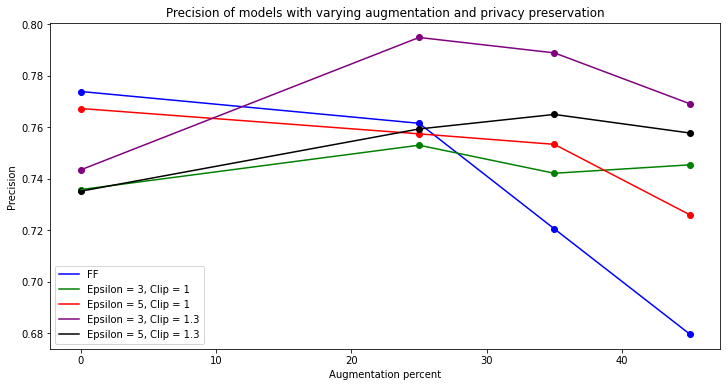

In [158]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(aug_levels,FF_prec, color='blue', label='FF')
ax.plot(aug_levels,SGD_3_1_prec, color='green', label='Epsilon = 3, Clip = 1')
ax.plot(aug_levels,SGD_5_1_prec, color='red', label='Epsilon = 5, Clip = 1')
ax.plot(aug_levels,SGD_3_13_prec, color='purple', label='Epsilon = 3, Clip = 1.3')
ax.plot(aug_levels,SGD_5_13_prec, color='black', label='Epsilon = 5, Clip = 1.3')

plt.scatter(aug_levels,FF_prec,color='blue')
plt.scatter(aug_levels,SGD_3_1_prec,color='green')
plt.scatter(aug_levels,SGD_5_1_prec,color='red')
plt.scatter(aug_levels,SGD_3_13_prec,color='purple')
plt.scatter(aug_levels,SGD_5_13_prec,color='black')


plt.title("Precision of models with varying augmentation and privacy preservation")
plt.xlabel('Augmentation percent')
plt.ylabel('Precision')
ax.legend()

plt.savefig('/content/drive/Shareddrives/SecureML/ProjectSubmission/Results/all_prec.png')
plt.show()

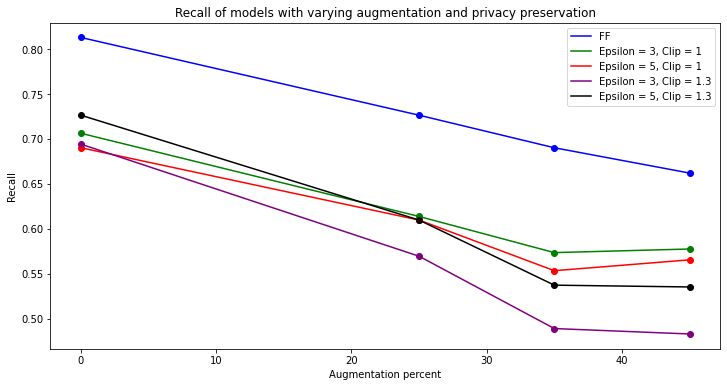

In [159]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(aug_levels,FF_rec, color='blue', label='FF')
ax.plot(aug_levels,SGD_3_1_rec, color='green', label='Epsilon = 3, Clip = 1')
ax.plot(aug_levels,SGD_5_1_rec, color='red', label='Epsilon = 5, Clip = 1')
ax.plot(aug_levels,SGD_3_13_rec, color='purple', label='Epsilon = 3, Clip = 1.3')
ax.plot(aug_levels,SGD_5_13_rec, color='black', label='Epsilon = 5, Clip = 1.3')

plt.scatter(aug_levels,FF_rec,color='blue')
plt.scatter(aug_levels,SGD_3_1_rec,color='green')
plt.scatter(aug_levels,SGD_5_1_rec,color='red')
plt.scatter(aug_levels,SGD_3_13_rec,color='purple')
plt.scatter(aug_levels,SGD_5_13_rec,color='black')


plt.title("Recall of models with varying augmentation and privacy preservation")
plt.xlabel('Augmentation percent')
plt.ylabel('Recall')
ax.legend()

plt.savefig('/content/drive/Shareddrives/SecureML/ProjectSubmission/Results/all_rec.png')
plt.show()

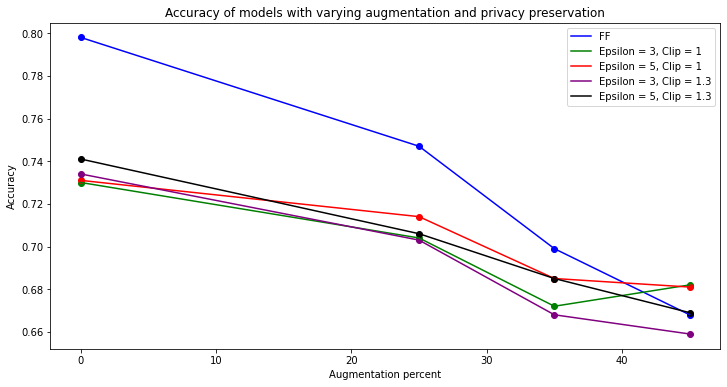

In [125]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(aug_levels,FF_no_DPSGD_acc, color='blue', label='FF')
ax.plot(aug_levels,FF_DPSGD_acc_3_1, color='green', label='Epsilon = 3, Clip = 1')
ax.plot(aug_levels,FF_DPSGD_acc_5_1, color='red', label='Epsilon = 5, Clip = 1')
ax.plot(aug_levels,FF_DPSGD_acc_3_13, color='purple', label='Epsilon = 3, Clip = 1.3')
ax.plot(aug_levels,FF_DPSGD_acc_5_13, color='black', label='Epsilon = 5, Clip = 1.3')

plt.scatter(aug_levels,FF_no_DPSGD_acc,color='blue')
plt.scatter(aug_levels,FF_DPSGD_acc_3_1,color='green')
plt.scatter(aug_levels,FF_DPSGD_acc_5_1,color='red')
plt.scatter(aug_levels,FF_DPSGD_acc_3_13,color='purple')
plt.scatter(aug_levels,FF_DPSGD_acc_5_13,color='black')


plt.title("Accuracy of models with varying augmentation and privacy preservation")
plt.xlabel('Augmentation percent')
plt.ylabel('Accuracy')
ax.legend()

plt.savefig('/content/drive/Shareddrives/SecureML/ProjectSubmission/Results/all_accuracy.png')
plt.show()

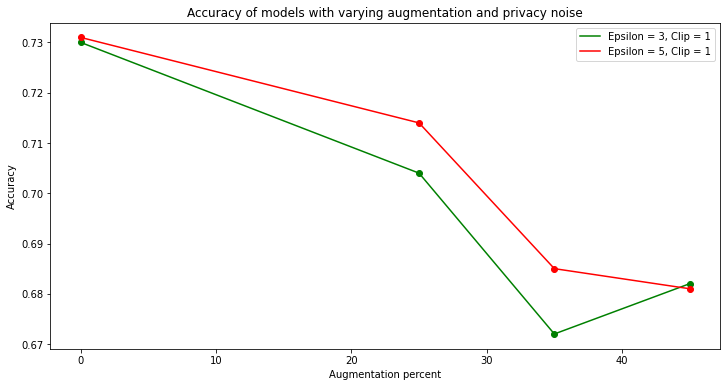

In [126]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))



ax.plot(aug_levels,FF_DPSGD_acc_3_1, color='green', label='Epsilon = 3, Clip = 1')
ax.plot(aug_levels,FF_DPSGD_acc_5_1, color='red', label='Epsilon = 5, Clip = 1')

plt.scatter(aug_levels,FF_DPSGD_acc_3_1,color='green')
plt.scatter(aug_levels,FF_DPSGD_acc_5_1,color='red')


plt.title("Accuracy of models with varying augmentation and privacy noise")
plt.xlabel('Augmentation percent')
plt.ylabel('Accuracy')
ax.legend()


plt.savefig('/content/drive/Shareddrives/SecureML/ProjectSubmission/Results/change_noise.png')
plt.show()

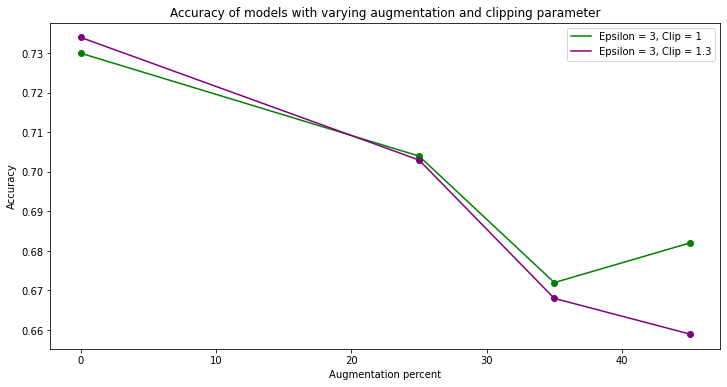

In [127]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))



ax.plot(aug_levels,FF_DPSGD_acc_3_1, color='green', label='Epsilon = 3, Clip = 1')
ax.plot(aug_levels,FF_DPSGD_acc_3_13, color='purple', label='Epsilon = 3, Clip = 1.3')


plt.scatter(aug_levels,FF_DPSGD_acc_3_1,color='green')
plt.scatter(aug_levels,FF_DPSGD_acc_3_13,color='purple')



plt.title("Accuracy of models with varying augmentation and clipping parameter")
plt.xlabel('Augmentation percent')
plt.ylabel('Accuracy')
ax.legend()

plt.savefig('/content/drive/Shareddrives/SecureML/ProjectSubmission/Results/change_clip1.png')
plt.show()

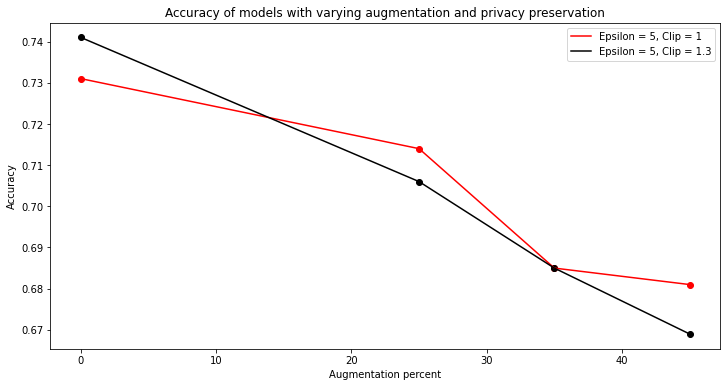

In [128]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))


ax.plot(aug_levels,FF_DPSGD_acc_5_1, color='red', label='Epsilon = 5, Clip = 1')
ax.plot(aug_levels,FF_DPSGD_acc_5_13, color='black', label='Epsilon = 5, Clip = 1.3')


plt.scatter(aug_levels,FF_DPSGD_acc_5_1,color='red')
plt.scatter(aug_levels,FF_DPSGD_acc_5_13,color='black')


plt.title("Accuracy of models with varying augmentation and privacy preservation")
plt.xlabel('Augmentation percent')
plt.ylabel('Accuracy')
ax.legend()

plt.savefig('/content/drive/Shareddrives/SecureML/ProjectSubmission/Results/change_clip2.png')
plt.show()